# Radar processing chain designed for the UK Met Office radar data.

Daniel Sanchez-Rivas<sup>1</sup> and Miguel A. Rico-Ramirez<sup>1</sup>

<sup>1</sup>Department of Civil Engineering, University of Bristol, Bristol, BS8 1TR, United Kingdom

## This notebook describes the process of retrieving, quality-check and processing raw C-band radar data collected by the operational UK Met Office radar network.

UK Met Office C-band rain radar dual-polarisation products are available at http://catalogue.ceda.ac.uk/uuid/82adec1f896af6169112d09cc1174499 (Met Office, 2003)

### Import relevant packages

wradlib is required to compute KDP, uncomment if needed.

In [1]:
import numpy as np
import towerpy as tp
import cartopy.crs as ccrs

# from wradlib.dp import process_raw_phidp_vulpiani as kdpvpi

%matplotlib notebook


You are using the Towerpy framework, an open source library for
working with polarimetric weather radar data.

If you find our work useful for your research, please consider citing our
following publication:





### Define working directory and file name

For this example, we'll use data collected at the Chenies radar site; *augzdr* stands for polarimetric data, *lp* for long-pulse and *el0* refers to collected at 0.5&deg; elevation angle.

In [2]:
rsite = 'chenies'
fdir = f'../datasets/{rsite}/y2020/lpel0/'
fname = (f'metoffice-c-band-rain-radar_{rsite}_202010032105_raw-dual-polar-'
         + 'augzdr-lp-el0.dat')

### Use Towerpy to read in the raw radar variables.

The **Rad_scan class** initialises a radar object. 

Within the **ukmo module**, the *ppi_ukmoraw* function provides an interface to read the current binary format used by the MO to store the radar data.

Note that the argument *exclude_vars* was used to discard the 'W [m/s]', 'SQI [-]' and 'CI [dB]'] variables, as they  will not be used at this stage.

<IPython.core.display.Javascript object>


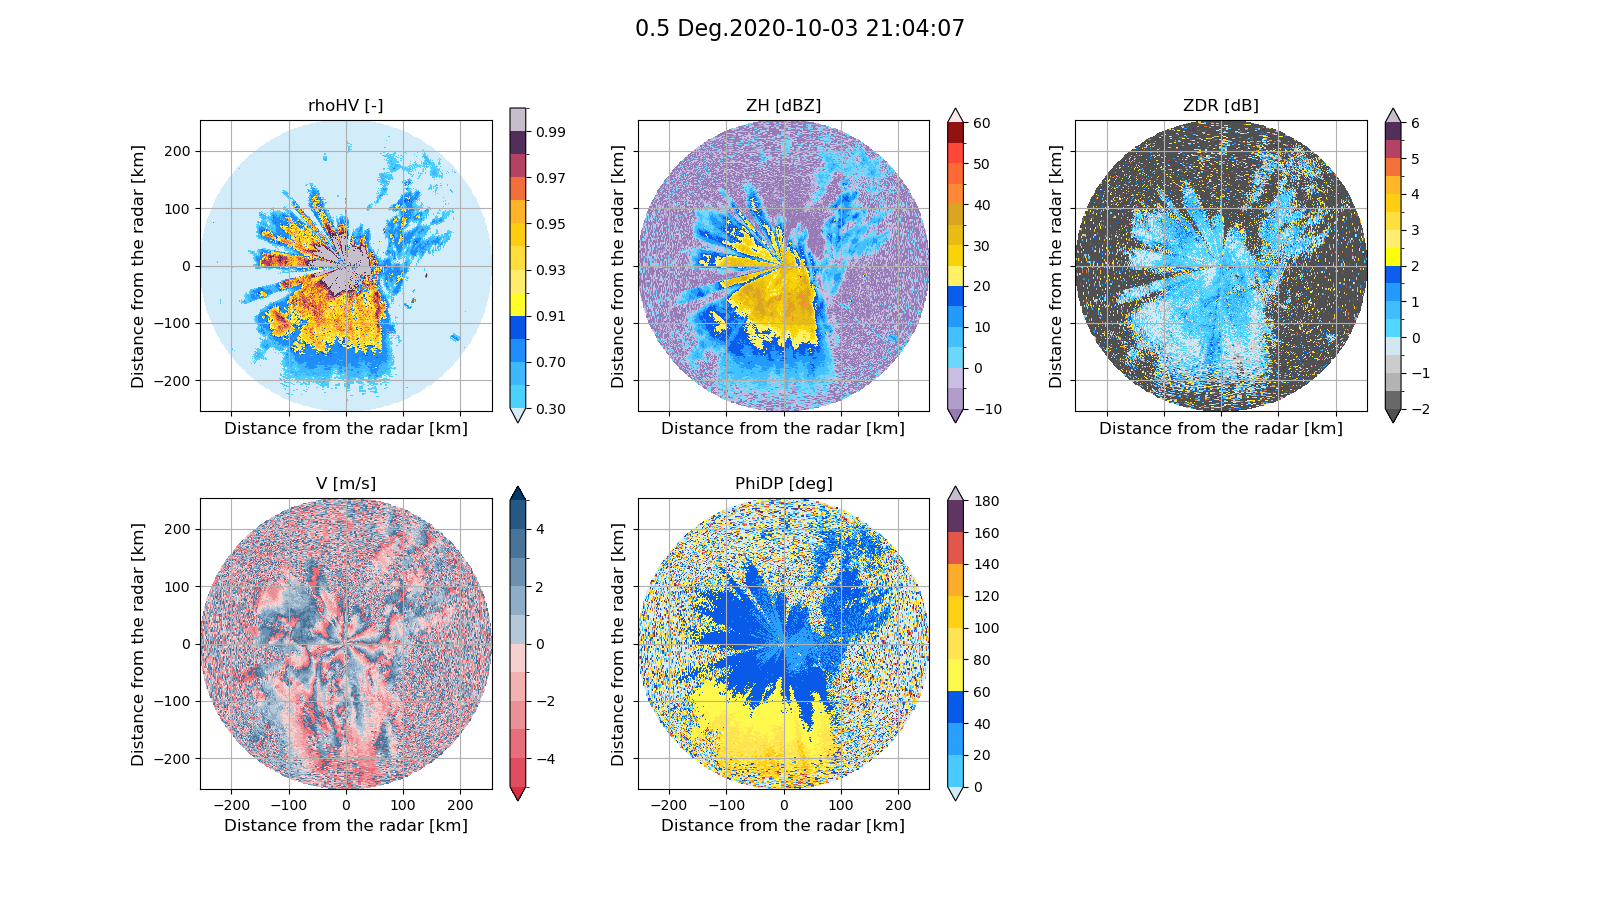

<IPython.core.display.Javascript object>


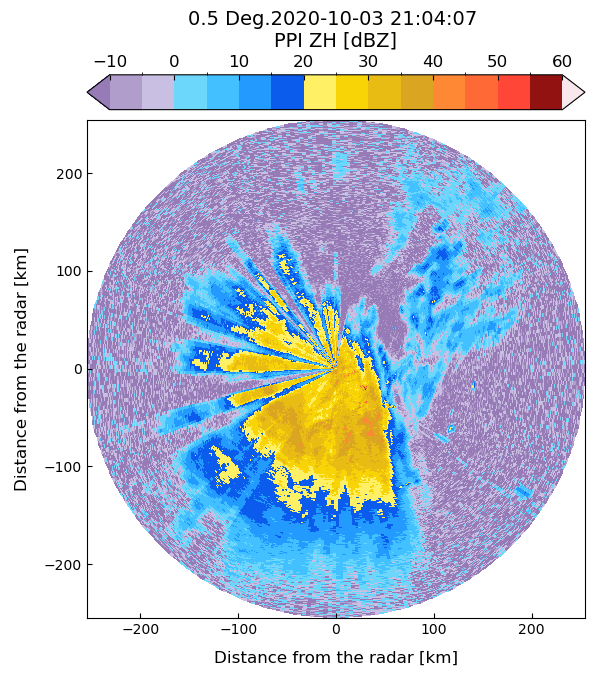

In [3]:
rdata = tp.io.ukmo.Rad_scan(fdir+fname, rsite)
rdata.ppi_ukmoraw(exclude_vars=['W [m/s]', 'SQI [-]', 'CI [dB]'])

# Plot all the radar variables
tp.datavis.rad_display.plot_setppi(rdata.georef, rdata.params, rdata.vars)

# Plot  ZH
tp.datavis.rad_display.plot_ppi(rdata.georef, rdata.params, rdata.vars)

### Compute the Signal-to-Noise-Ratio

We use the *signalnoiseratio* function to compute the Signal-to-Noise-Ratio (SNR) (in dB) and discard data using a reference noise value equal to 35 dB.
This value had been checked at all the UK Met office radar sites (valid only for long-pulse scans) and proved effective in removing noise within the scans.

The *data2correct* argument copies the original data and generates a new dictionary containing radar variables but SNR filtered.

<IPython.core.display.Javascript object>


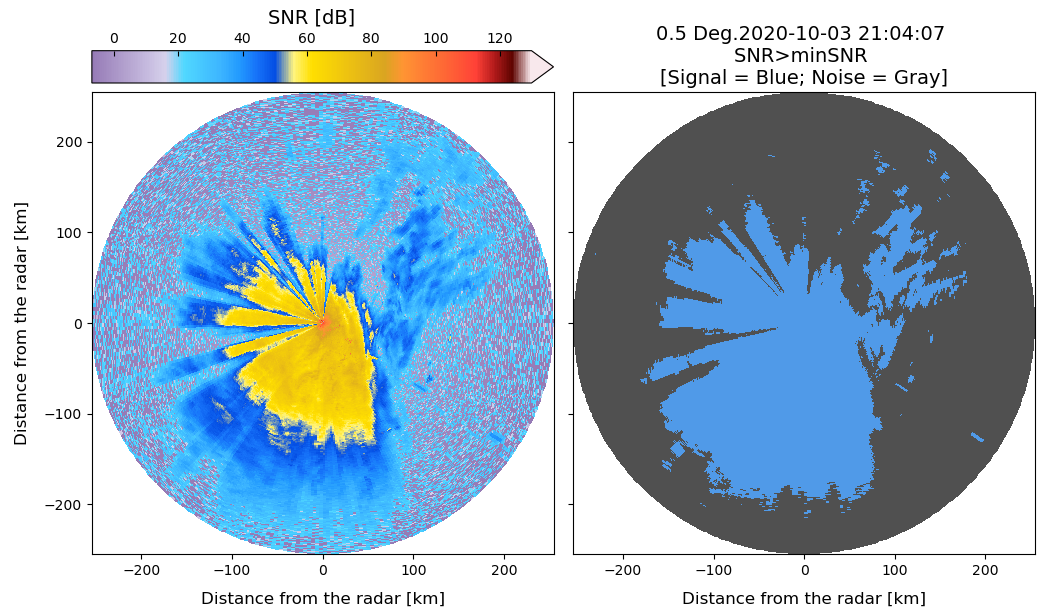

In [4]:
rsnr = tp.eclass.snr.SNR_Classif(rdata)
rsnr.signalnoiseratio(rdata.georef, rdata.params, rdata.vars, min_snr=35,
                      data2correct=rdata.vars, plot_method=True)

### Classification of non-meteorological echoes

Towerpy provides membership functions (MFS) to detect clutter echoes. These MFS were calibrated using C-band radar data. We plot the MFS using the *plot_mfs* function.

Note that the textures of polarimetric variables are a great clutter/meteorological echo discriminators!

<IPython.core.display.Javascript object>


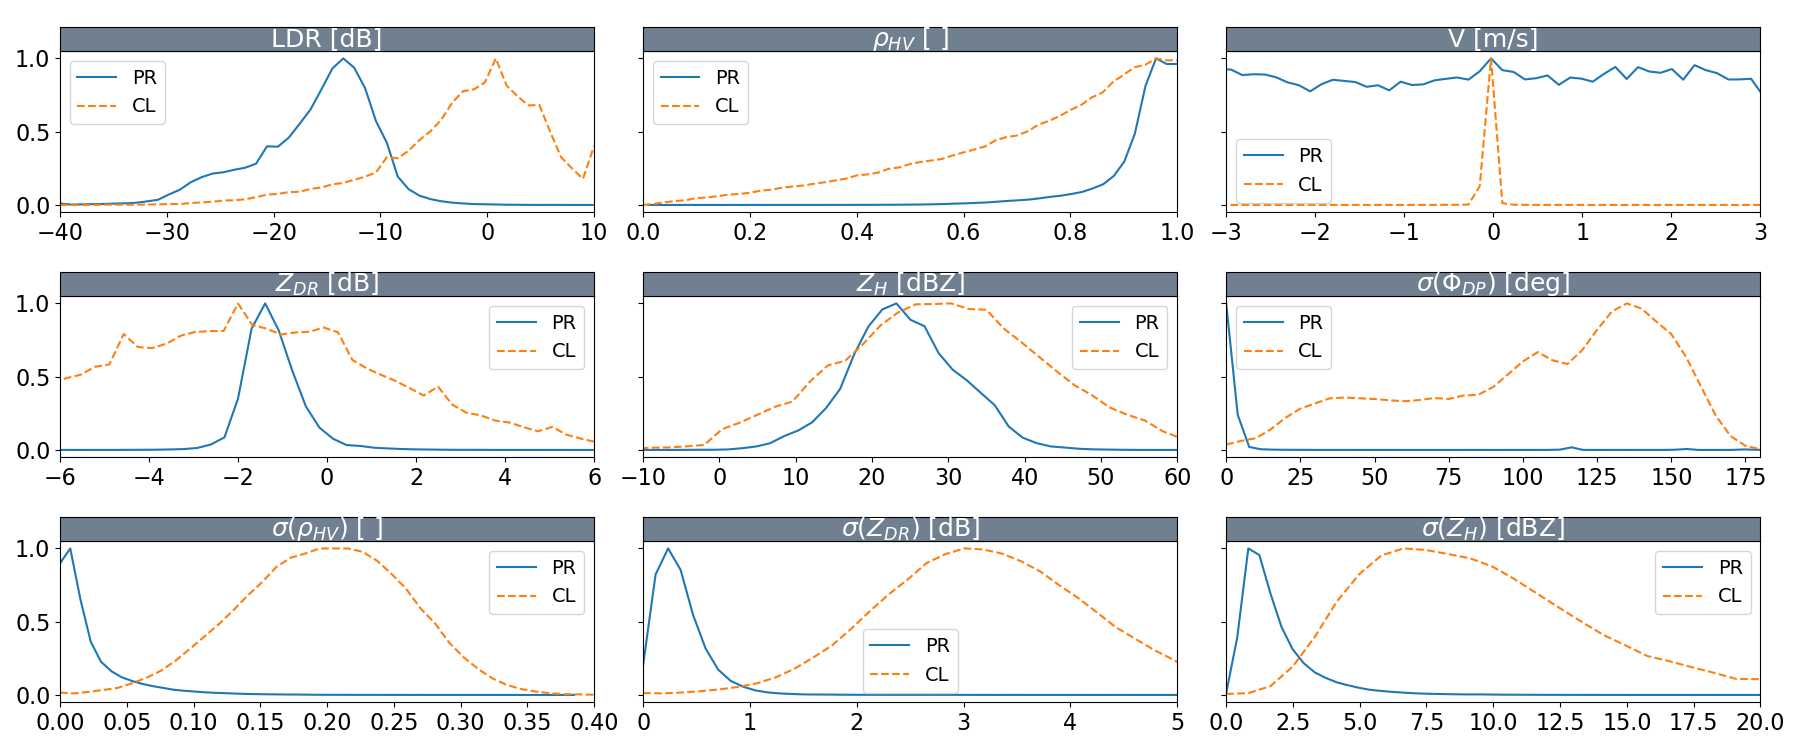

In [5]:
tp.datavis.rad_display.plot_mfs(f'../towerpy/eclass/mfs_cband/')

We use the *clutter_id* function to identify clutter echoes.

This function requires descriptors of the azimuth, gates and other georeferenced data (*rdata.georef*); radar technical details (*rdata.params*); radar variables (*rdata.vars*), and other arguments that can be customised by the user.

As we're working with Chenies radar data taken at 0.5 elevation angle, we load the array that contains the corresponding clutter map.

As above, The *data2correct* argument copies given data and generates a new dictionary containing radar variables but with the clutter echoes removed.

Clutter classification running time: 0.098 sec.


<IPython.core.display.Javascript object>


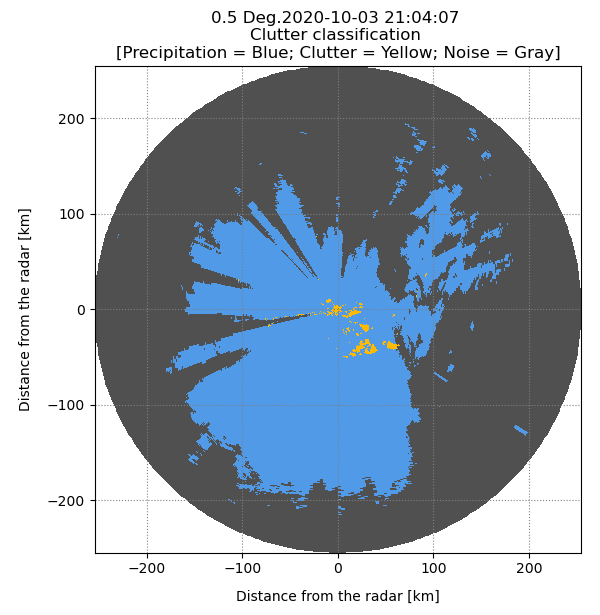

<IPython.core.display.Javascript object>


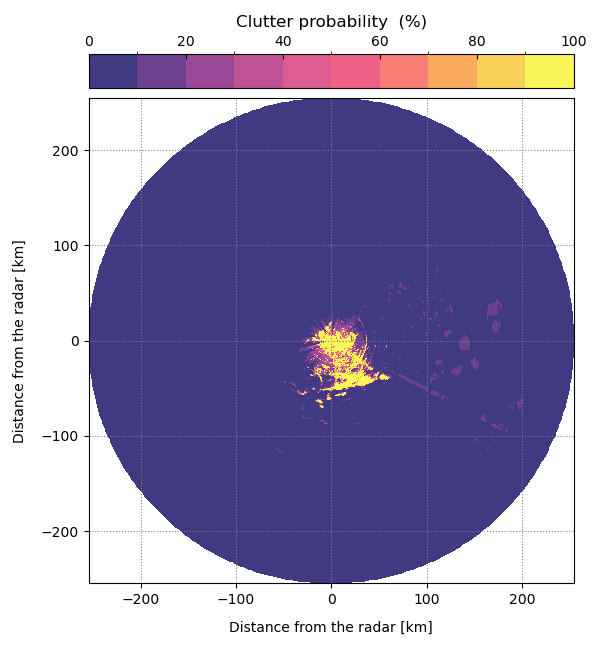

In [6]:
clmap = f'../towerpy/eclass/ukmo_cmaps/{rsite}/chenies_cluttermap_el0.dat'

rnme = tp.eclass.nme.NME_ID(rsnr)
rnme.clutter_id(rdata.georef, rdata.params, rdata.vars, binary_class=223,
                min_snr=rsnr.min_snr, clmap=np.loadtxt(clmap),
                data2correct=rdata.vars, plot_method=True)

### Definition of the melting layer boundaries

We create a MeltingLayer object to set the melting level height and the melting layer thickness.
These heights are important to delimit the rain region within the PPI scan. For this step, we estimated the melting layer boundaries from QVPs, but **assuming an isotropic melting layer.**

In [7]:
rmlyr = tp.ml.mlyr.MeltingLayer(rdata)
rmlyr.ml_top = 2
rmlyr.ml_thickness = 0.5

### Calibration of $Z_{DR}$

We create a ZDR_Calibration object to define and correct the $Z_{DR}$.
For this example, the $Z_{DR}$ offset is set as -0.28. This value was derived from QVPs and corroborated with birdbath scans.

In [8]:
rczdr = tp.calib.calib_zdr.ZDR_Calibration(rdata)
rczdr.offset_correction(rnme.vars['ZDR [dB]'],
                        zdr_offset=-0.28,
                        data2correct=rnme.vars)

### Attenuation correction

The next step is to correct the attenuation of the radar signal.

The *AttenuationCorrection* object contains two functions, *zh_correction* and *zdr_correction* that correct the attenuation on $Z_H$ and $Z_{DR}$, respectively.

The *zdr_correction* function requires the outputs of the $Z_H$ attenuation correction (i.e., $\alpha, A_h$) to compute the specific differential attenuation, 

**Note that the attenuation is computed up to a user-defined height that correspond to the rain region within the PPI scan.**

In [9]:
rattc = tp.attc.attc_zhzdr.AttenuationCorrection(rdata)
rattc.zh_correction(rdata.georef, rdata.params, rczdr.vars,
                    rnme.nme_classif['classif'], attc_method='ABRI',
                    mlyr=rmlyr, pdp_pxavr_azm=1, pdp_dmin=10,
                    pdp_pxavr_rng=round(4000/rdata.params['gateres [m]']))

rattc.zdr_correction(rdata.georef, rdata.params, rczdr.vars, rattc.vars,
                     rnme.nme_classif['classif'], mlyr=rmlyr, rhv_thld=0.98,
                     minbins=10, mov_avrgf_len=5, p2avrf=3,
                     beta_alpha_ratio=.2)

Z_H attenuation correction running time: 0.712 sec.
Z_{DR} attenuation correction running time: 0.187 sec.


We plot the results of the attenuation correction process using the *plot_attcorrection* function.

<IPython.core.display.Javascript object>


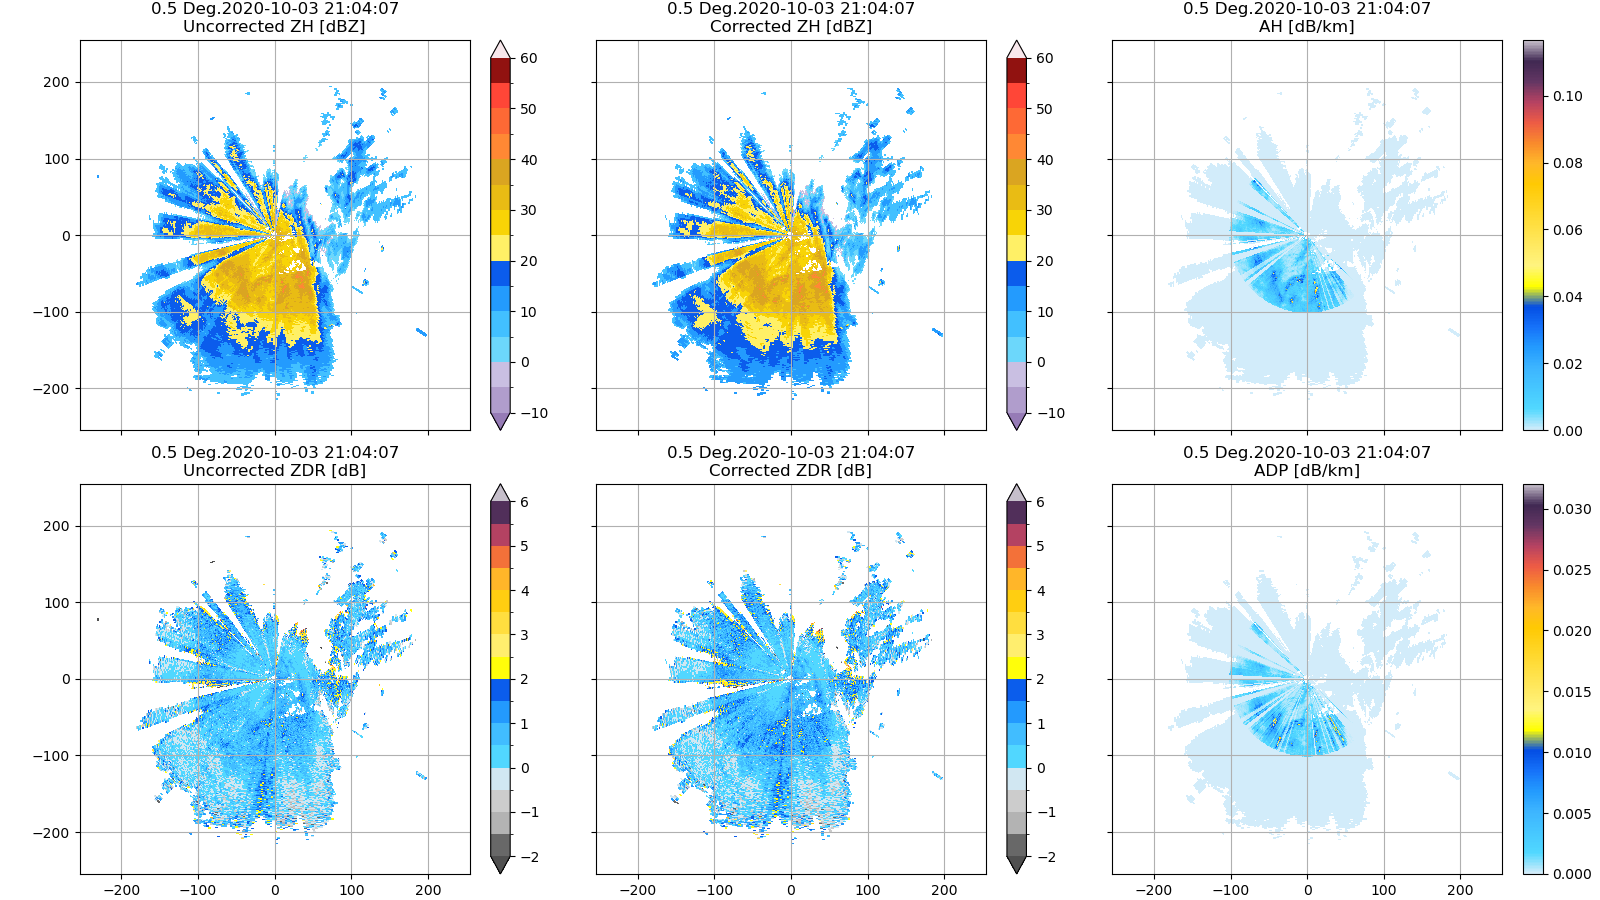

<IPython.core.display.Javascript object>


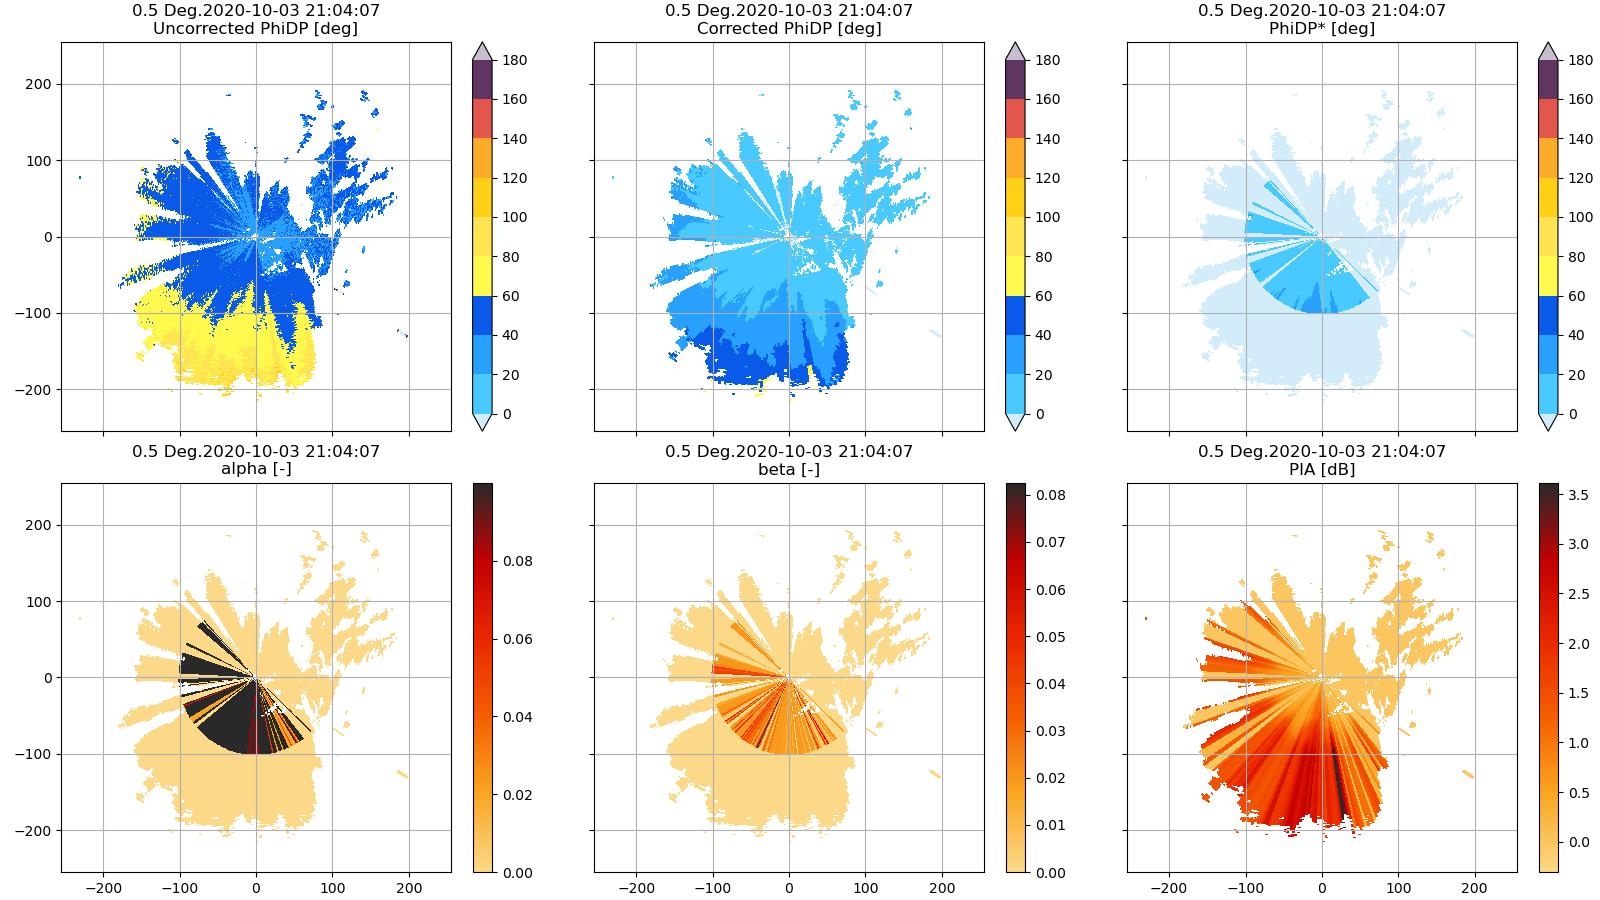

In [10]:
tp.datavis.rad_display.plot_attcorrection(rdata.georef, rdata.params,
                                          rczdr.vars,
                                          rattc.vars)

### $K_{DP}$ computation

For this example, we will not compute KDP, so we're leaving out this part. 

In [11]:
# rkdpv = {}

# KDP Vulpiani
# kdp_vulp = kdpvpi(rattc.vars['PhiDP [deg]'], winlen=11,
#                   dr=rdata.params['gateres [m]']/1000)
# rkdpv['PhiDP [deg]'] = kdp_vulp[0]
# rkdpv['KDP [deg/km]'] = kdp_vulp[1]
# rkdpv['PhiDP [deg]'][np.isnan(rattc.vars['ZH [dBZ]'])] = np.nan
# rkdpv['KDP [deg/km]'][np.isnan(rattc.vars['ZH [dBZ]'])] = np.nan

# tp.datavis.rad_display.plot_ppi(rdata.georef, rdata.params, rattc.vars,
#                                 var2plot='KDP [deg/km]',
#                                 vars_bounds={'KDP [deg/km]': (-1, 3, 17)})

# tp.datavis.rad_display.plot_ppi(rdata.georef, rdata.params, rkdpv,
#                                 var2plot='KDP [deg/km]',
#                                 vars_bounds={'KDP [deg/km]': (-1, 3, 17)})

### Quantitative Precipitation estimation

We use the **RadarQPE** class to initialise a radar QPE object. 

This class contains several rain estimators, and the coefficients used in each algorithm can be modified by the user depending on the radar frequency or the rainfall regime.

In [12]:
rqpe = tp.qpe.qpe_algs.RadarQPE(rdata)

rqpe.z_to_r(rattc.vars['ZH [dBZ]'], a=200, b=1.6, mlyr=rmlyr,
            beam_height=rdata.georef['beam_height [km]'])
rqpe.ah_to_r(rattc.vars['AH [dB/km]'], mlyr=rmlyr,
             beam_height=rdata.georef['beam_height [km]'])
rqpe.z_zdr_to_r1(rattc.vars['ZH [dBZ]'], rattc.vars['ZDR [dB]'], mlyr=rmlyr,
                 beam_height=rdata.georef['beam_height [km]'])
rqpe.z_zdr_to_r2(rattc.vars['ZH [dBZ]'], rattc.vars['ZDR [dB]'], mlyr=rmlyr,
                 a=0.0121, b=0.822, c=-1.7486,
                 beam_height=rdata.georef['beam_height [km]'])
# rqpe.kdp_to_r(rkdpv['KDP [deg/km]'], mlyr=rmlyr,
#               beam_height=rdata.georef['beam_height [km]'])
# rqpe.kdp_zdr_to_r(rkdpv['KDP [deg/km]'], rattc.vars['ZDR [dB]'], mlyr=rmlyr,
#                   beam_height=rdata.georef['beam_height [km]'])

In [13]:
help(rqpe.ah_to_r)

Help on method ah_to_r in module towerpy.qpe.qpe_algs:

ah_to_r(ah, a=294, b=0.89, beam_height=None, mlyr=None) method of towerpy.qpe.qpe_algs.RadarQPE instance
    Calculate the rain rate (R) from AH (in dB km^-1).
    
    Parameters
    ----------
    ah : float or array
        Floats that corresponds to specific attenuation, in dB/km.
    a, b : floats
        Parameters of the :math:`R(A_{H})` relationship
    beam_height : array, optional
        Height of the centre of the radar beam, in km.
    mlyr : class, optional
        Melting layer class containing the top and bottom boundaries of the
        ML. Only gates below the melting layer bottom (i.e. the rain region
        below the melting layer) are included in the correction. If None,
        the default values of the melting level and the thickness of the
        melting layer are set to 5 and 0.5, respectively.
    
    Returns
    -------
    R : dict
        Computed rain rates (in mm h^-1).
    
    Notes
    -----
  

We use the *plot_ppi* function to display the rain product on a map with a projection corresponding to the location of the radar.

<IPython.core.display.Javascript object>


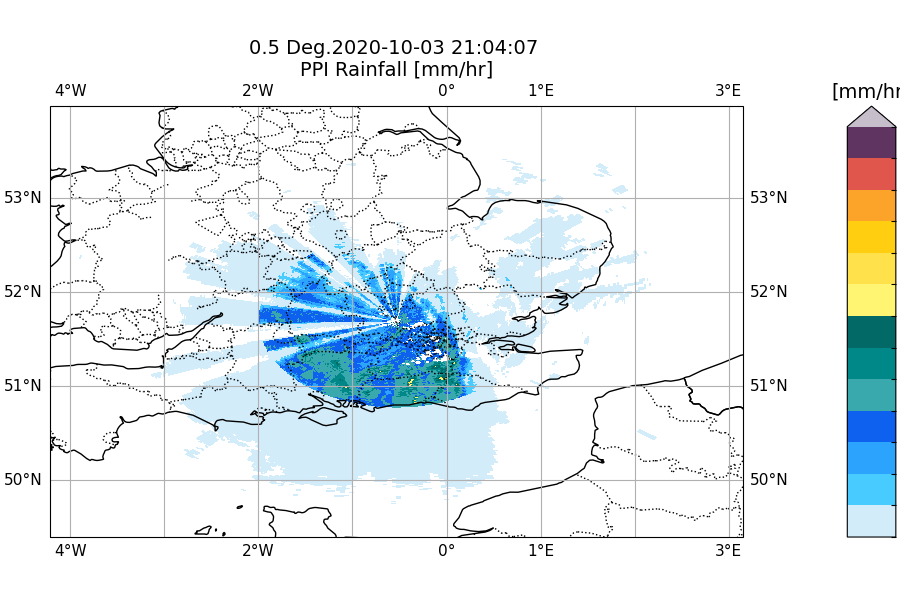

©Natural Earth; license: public domain


In [14]:
# Plot the radar data in a map
xgridp = rdata.georef['xgrid'] + rdata.params['easting [km]']
rdata.georef['xgrid_proj'] = xgridp
ygridp = rdata.georef['ygrid'] + rdata.params['northing [km]']
rdata.georef['ygrid_proj'] = ygridp

rdata.georef['xgrid_proj'] *= 1000
rdata.georef['ygrid_proj'] *= 1000

tp.datavis.rad_display.plot_ppi(rdata.georef, rdata.params, rqpe.r_z,
                                data_proj=ccrs.OSGB(approx=False),
                                cpy_feats={'status': True})

Finally, we use other functions within the **datavis** module to explore the radar data.

<IPython.core.display.Javascript object>


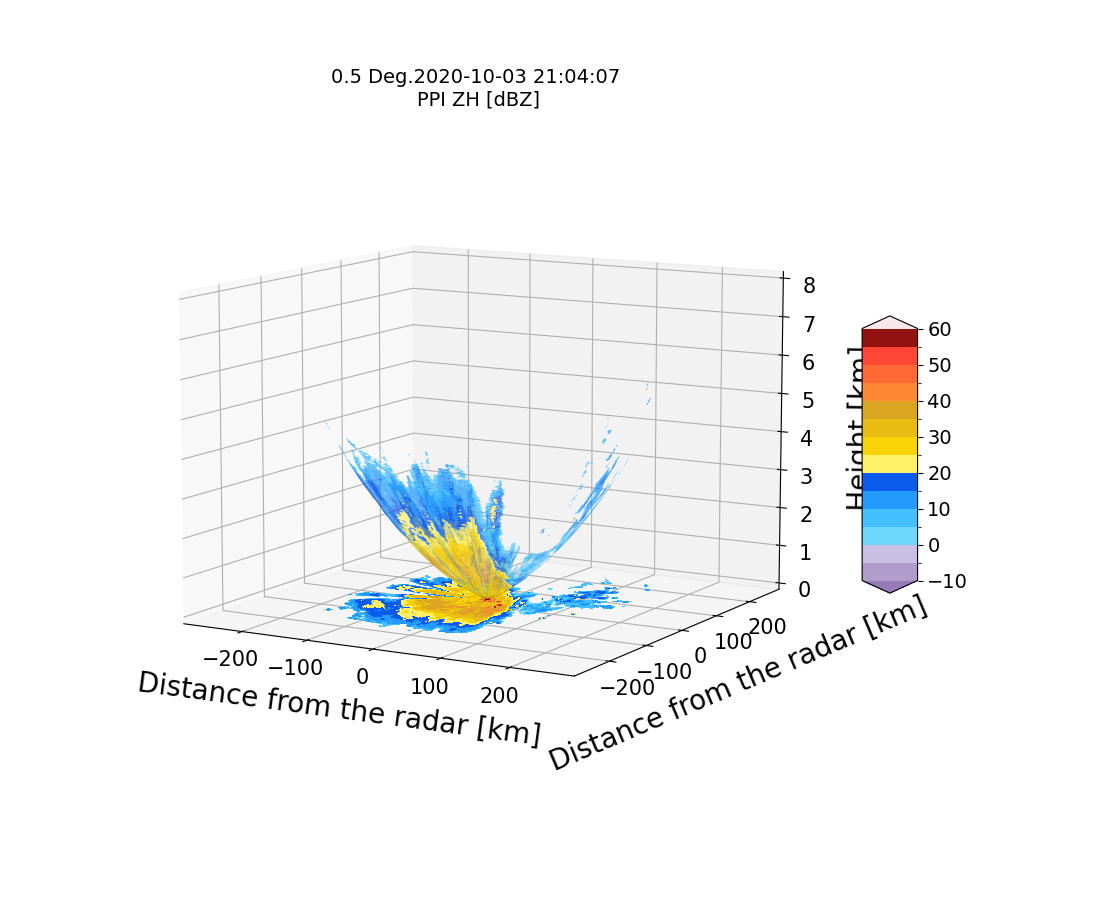

In [15]:
# Plot cone coverage
tp.datavis.rad_display.plot_cone_coverage(rdata.georef, rdata.params,
                                          rsnr.vars)

The rad_interactive module helps explore the PPI scans.

Moreover, the user can store the coordinates of the current position of the mouse pointer by pressing a number (0-9). This is useful for classifying pixels, e.g. 0 for meteorological echoes, 3 for noise and 5  for non-meteorological ones, in accordance with the *clutter_id* function.

<IPython.core.display.Javascript object>


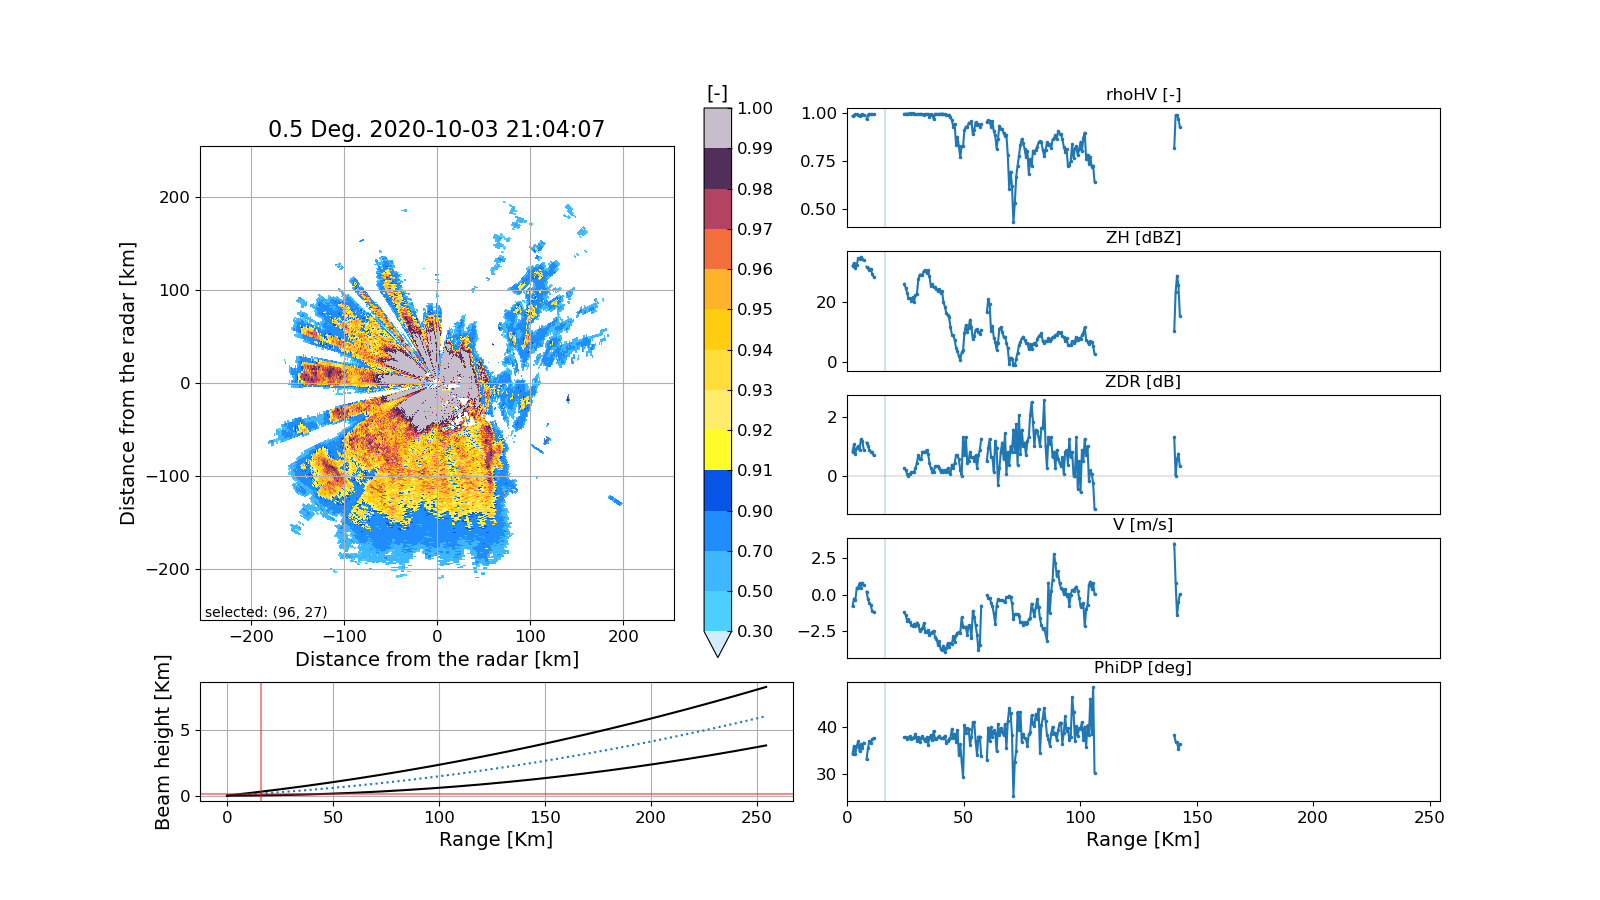


 
 
  Right-click on a pixel within the PPI to select its 
  azimuth or use the n and m keys to browse through the next 
  and previous azimuth.                                      
  Radial profiles of polarimetric variables will be shown at 
  the axes on the right.                                     
  Press a number (0-9) to store the coordinates and value    
  of the current position of the mouse pointer.              
  These coordinate can be retrieved at                       
  ppiexplorer.clickcoords                                    


In [16]:
# Plot an interactive PPI explorer
tp.datavis.rad_interactive.ppi_base(rdata.georef, rdata.params, rnme.vars,
                                    var2plot='rhoHV [-]')
ppiexplorer = tp.datavis.rad_interactive.PPI_Int()
# %%
# ppiexplorer.savearray2binfile(file_name='metoffice-c-band-rain-radar_jersey_202010030735_raw-dual-polar-augzdr-lp-el0.dat',
#                               dir2save='/home/enchiladaszen/Documents/radar_trials/metoffice/')

## References

Met Office (2003): Met Office Rain Radar Data from the NIMROD System. NCAS British Atmospheric Data Centre, 2022. http://catalogue.ceda.ac.uk/uuid/82adec1f896af6169112d09cc1174499